# Packages

In [1]:
import pandas as pd
import numpy as np
import random
import os
from datatable import fread

import torch
import torch.nn.functional as F
from torch                    import nn
from torch.optim              import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from skorch                   import NeuralNetClassifier
from skorch.callbacks         import LRScheduler
from skorch.helper            import DataFrameTransformer

# Import

In [2]:
#Data directory
datadir = 'data/'

#Import mouse voxelwise data to use for training
file_voxel = "MouseExpressionMatrix_voxel_coronal_maskcoronal_log2_grouped_imputed_labelled_scaled.csv"
filepath_voxel = os.path.join(datadir, file_voxel)

#Import expression matrix
dfExprVoxel = (fread(filepath_voxel, header = True)
               .to_pandas())

# Data preparation

Let's start by sampling a subset of voxels. Ultimately this isn't necessary, but the methods used for feature importance take some time to run, so as a proof of concept we'll use fewer data points.

In [3]:
#Sample some observations for training
dfExprVoxel = dfExprVoxel.sample(n = 10000, axis = 0, random_state = 1).copy()

Next we prepare the data for training, mainly by separating labels and inputs, and converting to numpy arrays.

In [4]:
#Sample 5000 observations for training
dfExprVoxel = dfExprVoxel.sample(n = 10000, axis = 0, random_state = 1).copy()

#Identify which columns contain labels
indLabels = dfExprVoxel.columns.str.match('Region')

#Extract matrix of gene expression values
dfInput = dfExprVoxel.loc[:,~indLabels]

#Column containing training labels
labelcol = 'Region67'

#Create a new data frame containing training labels
dfLabels = dfExprVoxel[[labelcol]].copy()

#Convert labels to category type
dfLabels.loc[:,labelcol] = dfLabels.loc[:,labelcol].astype('category')

# Create an instance of the data transformer
dftx = DataFrameTransformer()

# Fit and transform the input and label data frames
X_temp = dftx.fit_transform(dfInput)
y_temp = dftx.fit_transform(dfLabels)

# Extract the arrays from the dictionaries.
X = X_temp['X']
y = y_temp[labelcol]

# Training the network

First we specify some of the hyperparameters of the perceptron.

In [5]:
#Specify network parameters
hidden_units = 200
weight_decay = 1e-6
max_epochs = 200
learning_rate = 1e-5
device = 'cpu'
seed = 1

Next, define the architecture of neural network, and initialize an instance of it with the desired number of input units, hidden units, and output units.

In [6]:
#Set seed
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

#Define network architecture
class ClassifierModule(nn.Module):
    def __init__(
        self,
        input_units,
        output_units,
        hidden_units,
        apply_output_layer = True #Flag to apply output layer
    ):
        super(ClassifierModule, self).__init__()

        self.apply_output_layer = apply_output_layer

        self.hidden1 = nn.Linear(input_units, hidden_units)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_units, hidden_units)
        self.relu2 = nn.ReLU()
        self.hidden3 = nn.Linear(hidden_units, hidden_units)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(hidden_units, output_units)

#         self.hidden1 = nn.Linear(input_units, hidden_units)
#         self.hidden2 = nn.Linear(hidden_units, hidden_units)
#         self.hidden3 = nn.Linear(hidden_units, hidden_units)
#         self.output = nn.Linear(hidden_units, output_units)


    def forward(self, X, **kwargs):
        
        X = self.relu1(self.hidden1(X))
        X = self.relu2(self.hidden2(X))
        X = self.relu3(self.hidden3(X))
        
#         X = F.relu(self.hidden1(X))
#         X = F.relu(self.hidden2(X))
#         X = F.relu(self.hidden3(X))

        #If flag is True, apply output layer
        if self.apply_output_layer is True:
            X = F.softmax(self.output(X), dim = -1)

        return X

#Initialize network class with desired architecture
my_network = ClassifierModule(input_units = X.shape[1],
                              output_units = len(np.unique(y)),
                              hidden_units = hidden_units)
    

With the architecture specified, we now specify the optimization routine.

In [7]:
#Specify the optimization routine
net = NeuralNetClassifier(my_network,
                          train_split = None,
                          optimizer = AdamW,
                          optimizer__weight_decay = weight_decay,
                          max_epochs = max_epochs,
                          callbacks = [('lr_scheduler',
                                        LRScheduler(policy=OneCycleLR,
                                                    total_steps=max_epochs,
                                                    cycle_momentum=False,  
                                                    max_lr=learning_rate))],
                          device = device)

And finally we can fit the model.

In [8]:
#Train the network
net.fit(X, y)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        4.1945  0.0000  0.4529
      2        4.1930  0.0000  0.4488
      3        4.1914  0.0000  0.4503
      4        4.1897  0.0000  0.4499
      5        4.1879  0.0000  0.4483
      6        4.1859  0.0000  0.4517
      7        4.1836  0.0000  0.4496
      8        4.1809  0.0000  0.4499
      9        4.1778  0.0000  0.4487
     10        4.1742  0.0000  0.4554
     11        4.1699  0.0000  0.4513
     12        4.1648  0.0000  0.4497
     13        4.1587  0.0000  0.4497
     14        4.1513  0.0000  0.4503
     15        4.1421  0.0000  0.4507
     16        4.1306  0.0000  0.4520
     17        4.1160  0.0000  0.4501
     18        4.0973  0.0000  0.4505
     19        4.0728  0.0000  0.4520
     20        4.0402  0.0000  0.4741
     21        3.9969  0.0000  0.4543
     22        3.9399  0.0000  0.4508
     23        3.8663  0.0000  0.4505
     24        3.7736  0.0000  0.4557
     25     

    174        0.3033  0.0000  0.5203
    175        0.3030  0.0000  0.5185
    176        0.3027  0.0000  0.5192
    177        0.3025  0.0000  0.5201
    178        0.3023  0.0000  0.5257
    179        0.3021  0.0000  0.5200
    180        0.3019  0.0000  0.5173
    181        0.3017  0.0000  0.5203
    182        0.3016  0.0000  0.5228
    183        0.3015  0.0000  0.5190
    184        0.3013  0.0000  0.5225
    185        0.3012  0.0000  0.5201
    186        0.3011  0.0000  0.5173
    187        0.3011  0.0000  0.5215
    188        0.3010  0.0000  0.5209
    189        0.3009  0.0000  0.5209
    190        0.3009  0.0000  0.5223
    191        0.3008  0.0000  0.5219
    192        0.3008  0.0000  0.5206
    193        0.3008  0.0000  0.5216
    194        0.3007  0.0000  0.5229
    195        0.3007  0.0000  0.5235
    196        0.3007  0.0000  0.5204
    197        0.3007  0.0000  0.5211
    198        0.3007  0.0000  0.5202
    199        0.3007  0.0000  0.5210
    200     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (hidden1): Linear(in_features=2624, out_features=200, bias=True)
    (relu1): ReLU()
    (hidden2): Linear(in_features=200, out_features=200, bias=True)
    (relu2): ReLU()
    (hidden3): Linear(in_features=200, out_features=200, bias=True)
    (relu3): ReLU()
    (output): Linear(in_features=200, out_features=67, bias=True)
  ),
)

To confirm this is working as it should, let's compute the training accuracy:

In [9]:
#Convert input np array to torch tensor
X_tensor = torch.from_numpy(X).type(torch.FloatTensor)

#Apply network to input tensor to get output probabilities
y_prob = my_network(X_tensor).detach().numpy()

#Classify using most likely label
y_pred = np.argmax(y_prob, axis = 1)

#Accuracy
sum(y_pred == y)/len(y)

0.9148

# Identifying feature importance using integrated gradients

The first method introduced in the Captum tutorial for feature importance is called "integrated gradients". I don't know what this is, but it seems like it returns some values for each of the inputs corresponding to a given output label.

In [10]:
from captum.attr import IntegratedGradients

We need to specify what label we want to examine, so let's look at our dictionary

In [11]:
dfLabels['y'] = y
dfLabels.drop_duplicates()

,Region67,y
41104,Culmen,13
6127,Pons,46
18253,Olfactory areas-other,37
33205,Caudoputamen,4
14311,Ectorhinal area,17
...,...,...
42787,Declive (VI),14
29782,Agranular insular area,1
18116,Claustrum,7
9770,Midbrain raphe nuclei,34


Let's start by examining the classification of caudoputamen voxels.

In [12]:
#Structure we want to examine
target_struct = 'Caudoputamen'

#Associated dummy label
target_label = int(dfLabels
                .loc[dfLabels['Region67'] == target_struct, ['y']]
                .drop_duplicates()
                .values[0][0])

To use integrated gradients, we first instantiate the relevant class, with our network architecture as input. We then apply the "attribute" method, here specifying the label that we want to examine.

In [13]:
#Set up an integrated gradients class
ig = IntegratedGradients(my_network)

#Compute the attributes tensor for the desired target label
X_tensor.requires_grad_()
attr = ig.attribute(X_tensor, 
                    target = target_label, 
                    internal_batch_size = X.shape[0])

#Convert to numpy array
attr = attr.detach().numpy()

It's unclear to me what this output is, but let's at least examine the shape of it.

In [14]:
print(attr.shape)

(10000, 2624)


So this thing has the same shape as the input data, meaning rows corresponding to observations and columns to predictors. This gives us one value for each cell entry in our input matrix. Unclear what exactly those values mean...

In the Captum tutorial, they take averages over the observations for each of the input features. Let's do that here. We're also going to sort the average values to see which features are most "important".

In [15]:
#Grab the set of genes
genes = dfInput.columns.to_numpy()

#Array of x values for plotting
x_pos = np.arange(len(genes))

#Mean integrated gradient attributes over all 
#observations for each feature
attr_mean = np.mean(attr, axis = 0)

#Sorted attributes
attr_mean_sorted, genes_sorted = zip(*sorted(zip(attr_mean, genes)))

Now that we have these average feature importances corresponding to classification of the caudoputamen, let's plot them. 

Text(0.5, 0, 'Gene')

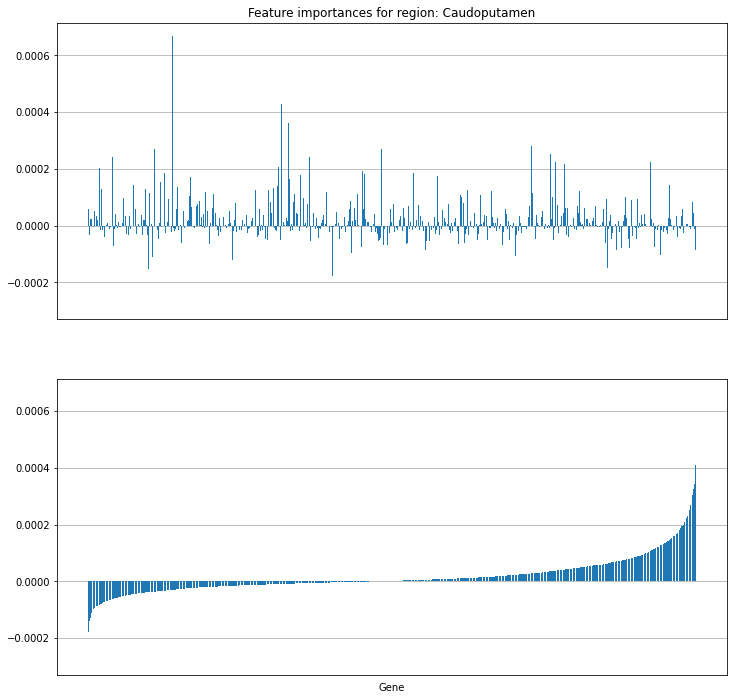

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize = (12,12))

axes[0].grid(zorder = 0, axis = 'y')
axes[0].bar(x_pos, attr_mean, zorder = 2)
axes[0].set_xticks([])
axes[0].set_title('Feature importances for region: {}'.format(target_struct))

axes[1].grid(zorder = 0, axis = 'y')
axes[1].bar(x_pos, attr_mean_sorted, align = 'center', zorder = 2)
axes[1].set_xticks([])
axes[1].set_xlabel('Gene')

Not super informative at this scale since there are so many inputs, but let's zoom in to take a look at what genes have the high attribute values.

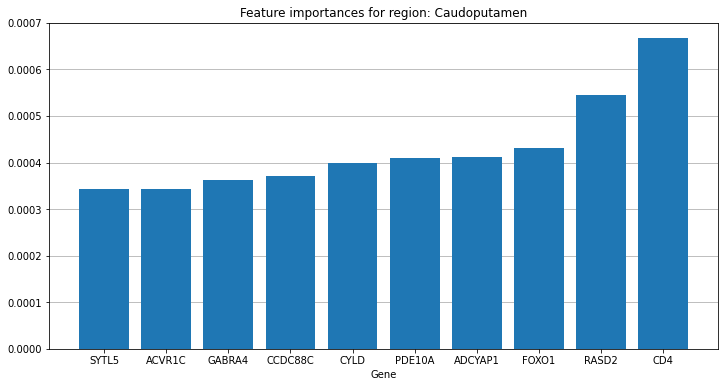

In [17]:
fig, ax = plt.subplots(figsize = (12,6))
ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos[-10:], attr_mean_sorted[-10:], align = 'center', zorder = 2)
ax.set_xticks(x_pos[-10:], genes_sorted[-10:])
ax.set_xlabel('Gene')
ax.set_title('Feature importances for region: {}'.format(target_struct))
plt.show()

Looks like CD4 is the most importance feature, followed by RASD2. What do these gene maps look like?

In [18]:
from pyminc.volumes.factory import volumeFromFile

#Anatomy and mask files
maskfile = 'AMBA/data/imaging/coronal_200um_coverage_bin0.8.mnc'
anatfile = 'AMBA/data/imaging/DSURQE_CCFv3_average_200um.mnc'

#Import volumes
mask = volumeFromFile(maskfile)
anat = volumeFromFile(anatfile)

#Convert to numpy
mask = np.array(mask.data)
anat = np.array(anat.data)

#Mask anatomy 
anat[mask == 0] = np.nan

In [19]:
#ISH files for genes mentioned above
exprfile1 = 'AMBA/data/expression/coronal/Cd4_74819249.mnc'
exprfile2 = 'AMBA/data/expression/coronal/Rasd2_73636089.mnc'

#Import
expr1 = volumeFromFile(exprfile1)
expr2 = volumeFromFile(exprfile2)

#Convert to numpy
expr1 = np.array(expr1.data)
expr2 = np.array(expr2.data)

#Mask
expr1[mask == 0] = np.nan
expr2[mask == 0] = np.nan

Text(0.5, 1.0, 'AMBA/data/expression/coronal/Rasd2_73636089.mnc')

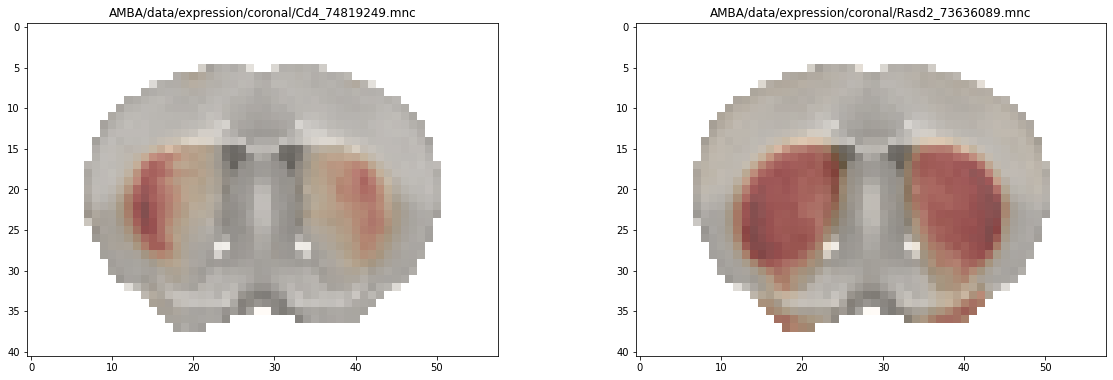

In [20]:
slc = 42
asp = anat.shape[1]/anat.shape[0]

anat_slice = anat[:,slc,:]
expr1_slice = expr1[:,slc,:]
expr2_slice = expr2[:,slc,:]

anat_slice = np.flip(anat_slice, axis = 0)
expr1_slice = np.flip(expr1_slice, axis = 0)
expr2_slice = np.flip(expr2_slice, axis = 0)

fig, axes = plt.subplots(1, 2, figsize = (2*10, 10/asp))

axes[0].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[0].imshow(expr1_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[0].set_title(exprfile1)

axes[1].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[1].imshow(expr2_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[1].set_title(exprfile2)

The two genes with the largest "importances" based on the integrated gradients method seem to have expression profiles that are localized to the caudoputamen. 

We know from this project that the striatum has really strong gene expression similarity between the mouse and human. What about a region that isn't as obvious? Let's look at the primary motor area. 

In [21]:
target_struct = 'Primary motor area'
target_label = int(dfLabels
                .loc[dfLabels['Region67'] == target_struct, ['y']]
                .drop_duplicates()
                .values[0][0])

In [22]:
attr = ig.attribute(X_tensor, 
                    target = target_label, 
                    internal_batch_size = X.shape[0])

#Convert to numpy array
attr = attr.detach().numpy()

attr_mean = np.mean(attr, axis = 0)

In [23]:
x_pos = np.arange(len(genes))
attr_mean_sorted, genes_sorted = zip(*sorted(zip(attr_mean, genes)))

Text(0.5, 0, 'Gene')

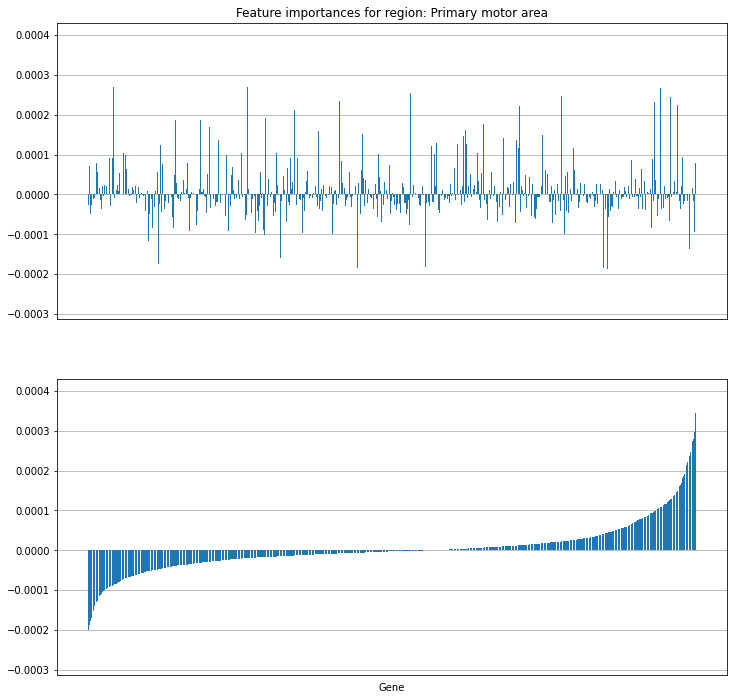

In [24]:
fig, axes = plt.subplots(2, 1, figsize = (12,12))

axes[0].grid(zorder = 0, axis = 'y')
axes[0].bar(x_pos, attr_mean, zorder = 2)
axes[0].set_xticks([])
axes[0].set_title('Feature importances for region: {}'.format(target_struct))

axes[1].grid(zorder = 0, axis = 'y')
axes[1].bar(x_pos, attr_mean_sorted, align = 'center', zorder = 2)
axes[1].set_xticks([])
axes[1].set_xlabel('Gene')

In this case, there isn't any one gene that is standing out above the rest. Regardless, what are the top genes here? 

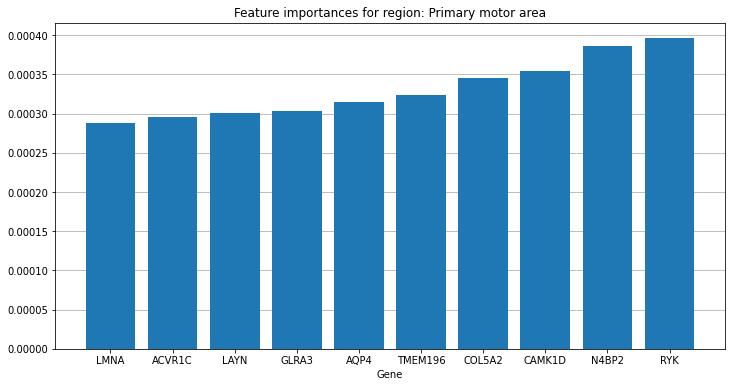

In [25]:
fig, ax = plt.subplots(figsize = (12,6))
ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos[-10:], attr_mean_sorted[-10:], align = 'center', zorder = 2)
ax.set_xticks(x_pos[-10:], genes_sorted[-10:])
ax.set_xlabel('Gene')
ax.set_title('Feature importances for region: {}'.format(target_struct))
plt.show()

More of a plateau here, but with 10,000 input observations, we find that RYK and N4BP2 are the top genes.

What do these look like? 

In [26]:
exprfile1 = 'AMBA/data/expression/coronal/Ryk_2541.mnc'
exprfile2 = 'AMBA/data/expression/coronal/N4bp2_74363354.mnc'

expr1 = volumeFromFile(exprfile1)
expr2 = volumeFromFile(exprfile2)

expr1 = np.array(expr1.data)
expr2 = np.array(expr2.data)

expr1[mask == 0] = np.nan
expr2[mask == 0] = np.nan

Text(0.5, 1.0, 'AMBA/data/expression/coronal/N4bp2_74363354.mnc')

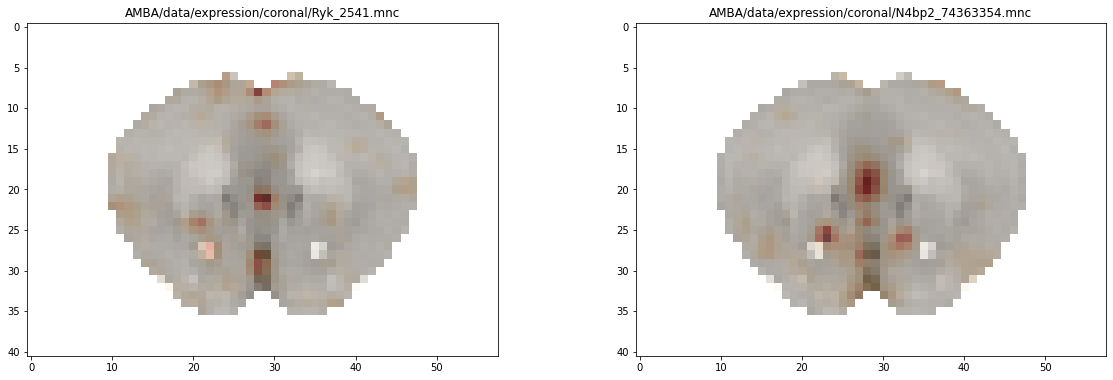

In [27]:
slc = 47

anat_slice = anat[:,slc,:]
expr1_slice = expr1[:,slc,:]
expr2_slice = expr2[:,slc,:]

anat_slice = np.flip(anat_slice, axis = 0)
expr1_slice = np.flip(expr1_slice, axis = 0)
expr2_slice = np.flip(expr2_slice, axis = 0)

fig, axes = plt.subplots(1, 2, figsize = (2*10, 10/asp))

axes[0].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[0].imshow(expr1_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[0].set_title(exprfile1)

axes[1].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[1].imshow(expr2_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[1].set_title(exprfile2)

Unclear if this is really localized to M1 or not. Would need a better slice series. This is also probably a regime where we don't have a small set of genes contributing to the classification. 

***

What the hell am I trying to do? 

We run our similarity analysis. Find that region X in the mouse is similar to region Y in the human. We want to know what drives that? That association is driven by the correlation over hidden neurons. That means that no one hidden neuron is responsible for this association. Rather the combination of the weights of the neurons. Then I guess the question is how do those weights relate back to the input genes? 

What else can we learn in the context of our usual analysis? 

***

Let's begin by importing the region-aggregated mouse and human expression data. 

In [42]:
# Mouse and human data to pass to network
file_mouse = 'MouseExpressionMatrix_ROI_Region67_scaled.csv'
file_human = 'HumanExpressionMatrix_ROI_Region88_scaled.csv'

#Attach paths
filepath_mouse = os.path.join(datadir, file_mouse) 
filepath_human = os.path.join(datadir, file_human)

# Import data
dfExprMouse = (fread(filepath_mouse, header = True)
               .to_pandas())
dfExprHuman = (fread(filepath_human, header = True)
               .to_pandas())

#Remove labels
dfInputMouse = dfExprMouse.loc[:, dfExprMouse.columns.isin(dfInput.columns)]
dfInputHuman = dfExprHuman.loc[:, dfExprHuman.columns.isin(dfInput.columns)]

Next we want to switch the mode of the neural network so that the output layer is the penultimate hidden layer rather than the probabililty layer.

In [43]:
net.module_.apply_output_layer = False

With the network configured the way we want, we want pass the mouse and human region aggregates through to get the latent space representations.

In [44]:
#Put mouse/human data into appropriate format for network        
X_Mouse = dftx.fit_transform(dfInputMouse)['X']
X_Human = dftx.fit_transform(dfInputHuman)['X']

#Apply the modified network to the mouse and human data to get the
#hidden units
dfMouseTransformed = pd.DataFrame(net.predict_proba(X_Mouse))
dfHumanTransformed = pd.DataFrame(net.predict_proba(X_Human))

dfMouseTransformed.shape

(67, 200)

There are 200 values for 67 regions, so this worked as intended. 

With our latent space representations, we can compute the correlation matrix. 

In [45]:
#Extract region names
mouse_regions = dfExprMouse['Region']
human_regions = dfExprHuman['Region']

#Convert latent space data to matrices
mat_mouse = dfMouseTransformed.to_numpy()
mat_human = dfHumanTransformed.to_numpy()

#Compute region-by-region correlations
mat_sim = np.corrcoef(mat_human, mat_mouse)
mat_sim = mat_sim[:len(human_regions), len(human_regions):]

#Store correlation in data frame
df_sim = pd.DataFrame(mat_sim,
                     index = human_regions,
                     columns = mouse_regions)

df_sim.head()

Region,Accessory olfactory bulb,Agranular insular area,Anterior cingulate area,Anterior olfactory nucleus,Caudoputamen,Central lobule,Cerebellar nuclei,Claustrum,Copula pyramidis,Cortical amygdalar area,...,Striatum ventral region,Subiculum,"Superior colliculus, sensory related",Supplemental somatosensory area,Taenia tecta,Temporal association areas,Thalamus,Uvula (IX),Ventral auditory area,Visual areas
Region,,,,,,,,,,,,,,,,,,,,,
amygdala,0.303690,0.503126,0.143495,0.683955,0.622075,-0.144127,-0.216056,0.662519,-0.145508,0.889725,...,0.791736,0.432747,-0.062316,0.161671,0.669603,0.443157,0.156638,-0.251350,0.270414,0.004337
anterior orbital gyrus,0.501748,0.796397,0.904002,0.411942,0.287773,0.019888,0.019457,0.750380,-0.067510,0.210442,...,0.174726,0.430974,0.021768,0.876802,0.329686,0.880628,0.073614,-0.055420,0.895704,0.824612
CA1 field,0.484316,0.738147,0.640247,0.599005,0.422664,-0.065566,-0.129086,0.721939,-0.106239,0.579569,...,0.435582,0.608258,-0.046181,0.546919,0.536434,0.771357,0.124435,-0.214818,0.661499,0.498325
CA2 field,0.469426,0.697827,0.528166,0.632665,0.447842,-0.060916,-0.152501,0.697413,-0.089286,0.655183,...,0.504134,0.543278,-0.079875,0.447923,0.579760,0.680350,0.175797,-0.226500,0.555328,0.342653
CA3 field,0.460967,0.681875,0.526169,0.616504,0.444276,-0.049692,-0.143725,0.683419,-0.084426,0.652695,...,0.497823,0.557134,-0.065847,0.438855,0.570626,0.675784,0.189572,-0.221195,0.551237,0.347943


Now that we've got our correlation matrix, we can take a look at the association between regions. Let's look at the caudoputamen again. Which human regions are most similar to the mouse caudoputamen?

In [39]:
df_sim['Caudoputamen'].sort_values(ascending = False).head()

Region
caudate nucleus          0.990312
putamen                  0.981042
nucleus accumbens        0.944501
septal nuclei            0.703712
substantia innominata    0.687868
Name: Caudoputamen, dtype: float64

Evidently we find that the caudate and putamen are the top hits, with near-perfect correlation. 

Now I guess the question we want to answer is what is driving these correlations?

A first step might be to take a look how these regions are represented in the latent space. 

Text(0.5, 1.0, 'Correlation of mouse caudoputamen to human caudate')

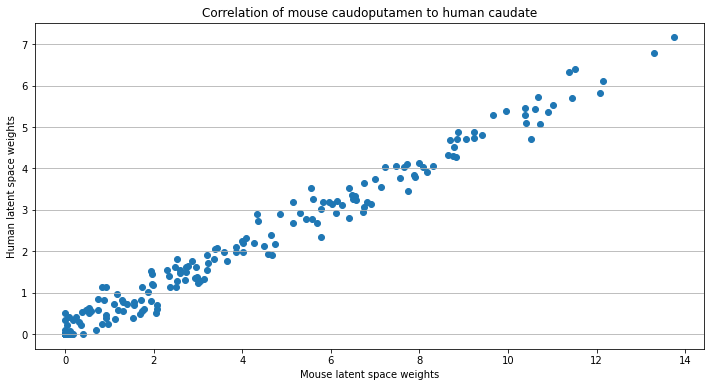

In [49]:
dfMouseTransformed.index = mouse_regions
dfHumanTransformed.index = human_regions

mouse_weights = dfMouseTransformed.loc['Caudoputamen'].to_numpy()
human_weights = dfHumanTransformed.loc['caudate nucleus'].to_numpy()
x_pos = np.arange(len(mouse_weights))

fig, ax = plt.subplots(figsize = (12,6))

ax.grid(zorder = 0, axis = 'y')
ax.scatter(mouse_weights, human_weights)
ax.set_xlabel('Mouse latent space weights')
ax.set_ylabel('Human latent space weights')
ax.set_title('Correlation of mouse caudoputamen to human caudate')

Evidently the mouse and human latent space vectors are very well aligned.

We can also take a look at the weights of the individual hidden neurons for one of these ROIs. 

Text(0.5, 1.0, 'Neuron weights of mouse caudoputamen')

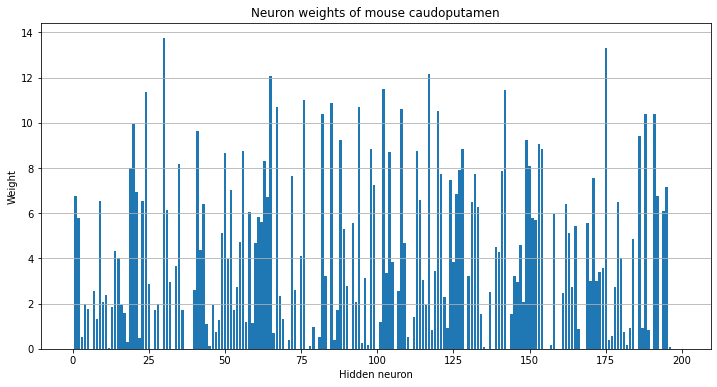

In [51]:
fig, ax = plt.subplots(figsize = (12,6))

ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos, mouse_weights)
ax.set_xlabel('Hidden neuron')
ax.set_ylabel('Weight')
ax.set_title('Neuron weights of mouse caudoputamen')

So the gene expression of the mouse caudoputamen isn't being projected onto one specific axis in the latent space. 

***

In [56]:
from captum.attr import LayerConductance

In [83]:
mat_mouse_cp = mat_mouse[mouse_regions == 'Caudoputamen',]
X_mouse_cp_tensor = torch.from_numpy(mat_mouse_cp).type(torch.FloatTensor)

In [84]:
net.module_.apply_output_layer = False

In [85]:
cond = LayerConductance(my_network, my_network.relu3)

In [86]:
cond_vals = cond.attribute(X_tensor,
#                            target = 4,
                           target = X_mouse_cp_tensor,
                           internal_batch_size = 2*X.shape[0])
cond_vals = cond_vals.detach().numpy()

AssertionError: Tensor target dimension torch.Size([2, 200]) is not valid. torch.Size([20000, 200])

In [61]:
cond_mean = np.mean(cond_vals, axis = 0)
x_pos = np.arange(len(cond_mean))

<BarContainer object of 200 artists>

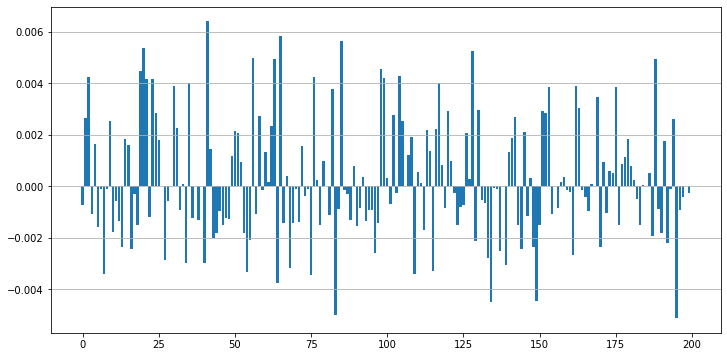

In [62]:
fig, ax = plt.subplots(figsize = (12,6))

ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos, cond_mean)

<BarContainer object of 10 artists>

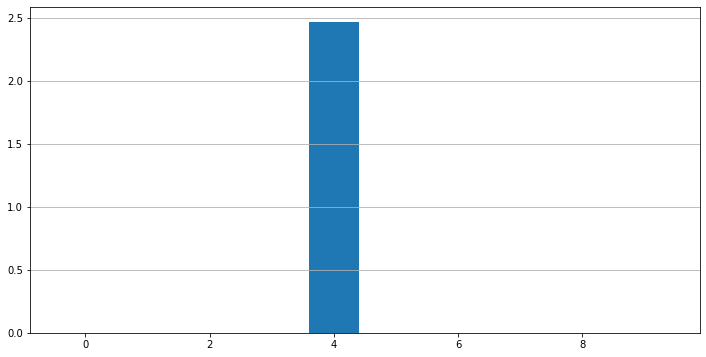

In [198]:
fig, ax = plt.subplots(figsize = (12,6))

ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos[:10], cond_mean[:10])

In [195]:
from captum.attr import NeuronConductance

In [196]:
neuron_cond = NeuronConductance(my_network, my_network.relu3)

In [199]:
neuron_cond_vals = neuron_cond.attribute(X_tensor, 
                                         neuron_selector = 4,
                                         target = 4, 
                                         internal_batch_size = 2*X.shape[0])

In [206]:
neuron_cond_vals = neuron_cond_vals.detach().numpy()
neuron_cond_mean = np.mean(neuron_cond_vals, axis = 0)
x_pos = np.arange(len(neuron_cond_mean))

<BarContainer object of 2624 artists>

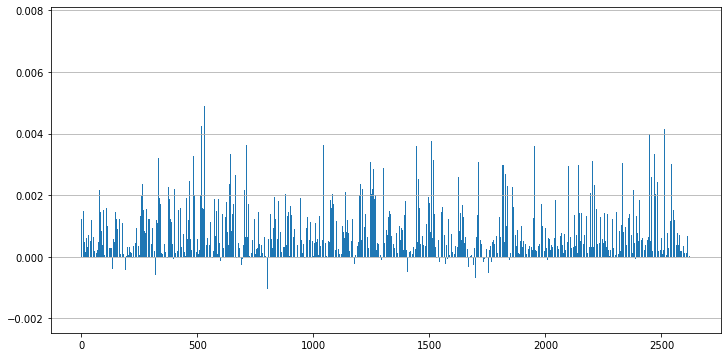

In [207]:
fig, ax = plt.subplots(figsize = (12,6))

ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos, neuron_cond_mean)